# Imports

In [18]:
import warnings
warnings.filterwarnings('ignore')
import scrapy
from scrapy.crawler import CrawlerProcess
import re
import pandas as pd
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse


# Translation

In [19]:
# Define the LAT_TO_HEB dictionary
LAT_TO_HEB = {
    ')': 'א',
    'b': 'ב',
    'g': 'ג',
    'd': 'ד',
    'h': 'ה',
    'w': 'ו',
    'z': 'ז',
    'x': 'ח',
    'T': 'ט',
    'y': 'י',
    'k': 'כ',
    'K': 'ך',
    'l': 'ל',
    'm': 'מ',
    'M': 'ם',
    'n': 'נ',
    'N': 'ן',
    's': 'ס',
    '(': 'ע',
    'p': 'פ',
    'P': 'ף',
    'c': 'צ',
    'C': 'ץ',
    'q': 'ק',
    'r': 'ר',
    '$': 'ש',
    '&': 'שׂ',
    't': 'ת',
    '"': '',
    '^': '',
}

# Function to replace Latin characters with Hebrew
def replace_with_heb_chars(word: str) -> str:
    return ''.join(LAT_TO_HEB.get(char, char) for char in word)

def lat_to_heb(st: str) -> str:
    words = st.split()
    heb_words = [replace_with_heb_chars(word) for word in words]
    return ' '.join(heb_words)

# Define all the transformation functions
def replace_sub(orig_str: str, start: int, end: int, replacement: str) -> str:
    return orig_str[:start] + replacement + orig_str[end + 1:]

def r3_slash_slash2(st: str) -> str:
    cont1 = r"(?P<cont1>\\[^/]+|[^/ ]+)"
    cont2 = r"(?P<cont2>[^/]*/)"
    return re.sub(rf"{cont1}\s*/{cont2}", '\g<cont2>', st)

def r3_slash_slash(st: str) -> str:
    r3 = re.compile(r'(cont) "/" (cont) "/"')
    matches = r3.finditer(st)
    if not matches:
        return st
    new_st = st
    for match in reversed(list(matches)):
        start = match.start()
        end = match.end()
        new_st = replace_sub(
            new_st,
            start,
            end - 1,
            new_st[match.start(1): match.end(1)]
        )
    return new_st

def r_5_4_hash_hash(st: str) -> str:
    return re.sub(r'#[^#]*#', '', st)

def r2_squigglie_slash_slash(st: str) -> str:
    return re.sub(r'"/"', '', st)

def r11_double_squiggles(st: str) -> str:
    return re.sub(r'\{\{|\}\}', '', st)

def r12_14_question(st: str) -> str:
    return re.sub(r'\?', '', st)

def r1_squiggles(st: str) -> str:
    return re.sub(r'\{[^{}]*\}', '', st)

def r6_quotes(st: str) -> str:
    # Remove all substrings enclosed in double quotes
    return re.sub(r'"[^"]*"', '', st)

def r8_7_dots(st: str) -> str:
    return re.sub(r'\.{2,}', '', st)

def r9_chevrons(st: str) -> str:
    return re.sub(r'[<>]', '', st)

def r10_carets(st: str) -> str:
    return re.sub(r'\^[^^]*\^', '', st)

def r13_backslash(st: str) -> str:
    return st.replace('\\', '')

def r15_caret(st: str) -> str:
    return re.sub(r'\^', '', st)

def r16_comma(st: str) -> str:
    return re.sub(r',', '', st)

def r17_plus(st: str) -> str:
    return re.sub(r'\+', '', st)

def r18_at_equals_dash(st: str) -> str:
    return st.replace('@', ' ').replace('=', '').replace('-', '')

def r19_squiggle_space(st: str) -> str:
    return st.replace('{ ', ' ')

def r20_remove_braces(st: str) -> str:
    return st.replace('[', '').replace(']', '')

def r21_remove_bang(st: str) -> str:
    return st.replace('!', '')

def r22_backtick_to_space(st: str) -> str:
    return st.replace('`', ' ')

def r_WS(st: str) -> str:
    st = re.sub(r' +', ' ', st)
    st = st.strip()
    return st

def transform_str(st: str) -> str:
    st = lat_to_heb(st)  # Apply Latin to Hebrew transformation first
    rules = [
        r9_chevrons,
        r_5_4_hash_hash,
        r16_comma,
        r12_14_question,
        r10_carets,
        r15_caret,
        r17_plus,
        r8_7_dots,
        r3_slash_slash2,
        r6_quotes,
        r13_backslash,
        r2_squigglie_slash_slash,
        r11_double_squiggles,
        r1_squiggles,
        r18_at_equals_dash,
        r19_squiggle_space,
        r20_remove_braces,
        r21_remove_bang,
        r22_backtick_to_space,
        r_WS
    ]

    for f in rules:
        st = f(st)
    return st

def apply_transformation(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    df[f'{column_name}_transformed'] = df[column_name].apply(transform_str)
    return df

if __name__ == "__main__":
    # Create a sample DataFrame
    df_check = pd.DataFrame({'text': ['^tn)^', '"lytny"']})
    
    # Apply transformation
    df_check = apply_transformation(df_check, 'text')
    
    # Display the transformed DataFrame
df_check

,text,text_transformed
0,^tn)^,תנא
1,"""lytny""",ליתני


# Sort

In [20]:

def replace_x_in_coord(url: str) -> str:
    # Parse the URL
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    
    # Get and modify the 'coord' parameter
    coord = query_params.get('coord', [''])[0]
    coord = coord.replace('x', '1')
    
    # Update query parameters
    query_params['coord'] = [coord]
    
    # Rebuild the URL with updated parameters
    new_query_string = urlencode(query_params, doseq=True)
    new_url = urlunparse((
        parsed_url.scheme,
        parsed_url.netloc,
        parsed_url.path,
        parsed_url.params,
        new_query_string,
        parsed_url.fragment
    ))
    
    return new_url




In [21]:

def sort_by_coord_and_word(df, url_column='url'):
    # Extract 'coord' and 'word' values using str.extract
    df[['coord', 'word']] = df[url_column].str.extract(r'coord=(\d+)&word=(\d+)')

    # Ignore the first 7 digits of 'coord', and handle NaN values by filling them with a placeholder
    df['coord'] = df['coord'].str[7:].fillna('0')
    df['word'] = df['word'].fillna('0')

    # Convert 'coord' and 'word' to integers for correct sorting
    df['coord'] = df['coord'].astype(int)
    df['word'] = df['word'].astype(int)

    # Sort by 'coord' and then by 'word'
    sorted_df = df.sort_values(by=['coord', 'word'], ascending=[True, True])

    # Drop the temporary columns 'coord' and 'word'
    sorted_df = sorted_df.drop(columns=['coord', 'word'])

    return sorted_df

# Clean text

In [22]:
import pandas as pd
import numpy as np

def clean_text(text):
    # Check if the text is None or not a string
    if text is None or not isinstance(text, str):
        return None  # Return an empty string if the input is None or not a string
    
    # Remove literal '\n' characters
    text = text.replace('\\n', '').strip()
    
    # Remove the first word
    words = text.split()
    if len(words) > 1:
        text = ' '.join(words[1:])
    
    # Keep only the last word after '='
    parts = text.split('=')
    if len(parts) > 1 and parts[-1].strip():
        last_part = parts[-1].strip()
        words = last_part.split()
        text = words[-1] if words else ''
    
    # Replace specific phrase
    if "is no data for this word" in text:
        text = "No data"
    
    return text

def clean_text_df(df):
    for i in range(5):  # Adjust the range if you have more or fewer columns
        column_name = f'lexicon_{i}'
        # Apply clean_text to each column
        df[column_name] = df[column_name].apply(clean_text)

    return df



# Merge lexicon

In [23]:
import numpy as np

def merge_lexicons(row):
    merged_text = []
    for i in range(5):  # Adjust the range if you have more or fewer columns
        column_name = f'lexicon_{i}'
        text = row[column_name]
        
        # Skip None or NaN values
        if pd.isna(text) or text == 'None' or text == 'nan':
            continue
        
        # Split text by '|'
        parts = text.split('|')
        
        # Append non-empty parts
        merged_text.extend(part.strip() for part in parts if part.strip())
    
    # Join all parts with '|'
    return ' | '.join(merged_text)




# URL to location

In [24]:
def url_to_location(df, url_column='url'):
    # Extract 'coord' and 'word' values using str.extract
    df[['coord', 'word']] = df[url_column].str.extract(r'coord=(\d+)&word=(\d+)')

    # Define a function to parse and transform the 'coord' field and handle 'word'
    def parse_coord_and_word(coord, word):
        if pd.isna(coord):
            return (0, '000', 0, '00', 0)  # Default values for missing cases
        coord = coord.zfill(12)  # Ensure the coord string is zero-padded to 12 digits
        masekhet = coord[:5]  # Masekhet: first 5 digits
        page = coord[7:10].zfill(3)  # Page: next 2 digits, padded to 3 digits
        side = int(coord[10])  # Side: next digit
        line = coord[11:].zfill(2)  # Line: last 2 digits, padded to 2 digits
        word_value = int(word) if not pd.isna(word) else 0  # Handle missing word
        return (masekhet, page, side, line, word_value)

    # Apply the parsing function to the 'coord' and 'word' columns
    df[['masekhet', 'page', 'side', 'line', 'word']] = df.apply(lambda row: pd.Series(parse_coord_and_word(row['coord'], row['word'])), axis=1)

    # Create the formatted column and replace the original 'url' column with it
    df[url_column] = df.apply(lambda row: f"Masekhet: {row['masekhet']}, Page: {row['page']}, Side: {row['side']}, Line: {row['line']}, Word: {row['word']}", axis=1)

    # Sort by 'masekhet', 'page', 'side', 'line', and then by 'word'
    sorted_df = df.sort_values(by=['masekhet', 'page', 'side', 'line', 'word'], ascending=[True, True, True, True, True])

    # Drop the temporary columns 'coord', 'masekhet', 'page', 'side', 'line'
    sorted_df = sorted_df.drop(columns=['coord', 'masekhet', 'page', 'side', 'line','word'])

    return sorted_df

# Data Process

In [25]:
def data_process(file_path): 
    
    # Read the JSON file into a DataFrame
    df = pd.read_json(file_path)

    # Apply transformation
    df = apply_transformation(df, 'text')

    # Apply the transformation
    df['url'] = df['url'].apply(replace_x_in_coord)

    # Assuming your DataFrame is named 'df' and has a column 'url'
    sorted_df = sort_by_coord_and_word(df)
    
    clean_df = clean_text_df(sorted_df)
    
    clean_df['merged_lexicon'] = clean_df.apply(merge_lexicons, axis=1)
    
    df = url_to_location(clean_df)


    # Display the sorted DataFrame
    return df

# Convert to Dataframe

In [26]:

# Path to the JSON file
file_path = r'C:\Users\USER\Desktop\Final_Project\Data\Masekhet_ber.json'

# Read the JSON file into a DataFrame
df = pd.read_json(file_path)

# Display the DataFrame
df

,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4
0,tn),bablex.php?coord=7100101002115&word=0,\n\n\ntn) noun sg. emphatic,None,None,None,NaN
1,"""(rbyt""",bablex.php?coord=7100101002124&word=1,"there is no data for this word, it may be unde...",None,None,None,NaN
2,lytny,bablex.php?coord=7100101002124&word=0,\n\n\ntny verb G,None,None,None,NaN
3,tn),bablex.php?coord=7100101002126&word=0,\n\n\ntny verb G,None,None,None,NaN
4,tn),bablex.php?coord=7100101002125&word=1,\n\n\ntn) noun sg. emphatic,None,None,None,NaN
...,...,...,...,...,...,...,...
17532,wtw;,bablex.php?coord=7100101002116&word=0,\n\n\nw_ c,tw a = tw X --> twb X,None,None,NaN
17533,"""m)ymty""",bablex.php?coord=7100101002115&word=4,"there is no data for this word, it may be unde...",None,None,None,NaN
17534,dqtny,bablex.php?coord=7100101002115&word=3,\n\n\nd_ c = d_ c --> dy c,tny verb G,None,None,NaN
17535,q)y,bablex.php?coord=7100101002115&word=2,\n\n\nqwm verb G,None,None,None,NaN


In [27]:
# Count the number of None and NaN values in each column
null_counts = df.isnull().sum()

# Display the count of None and NaN values for each column
print(null_counts)

text             0
url              0
lexicon_0        0
lexicon_1    14246
lexicon_2    17490
lexicon_3    17533
lexicon_4    17537
dtype: int64


In [28]:
# To check unique values in a specific column, e.g., 'text'
unique_values = df['lexicon_3'].unique()

# Display the unique values
print(unique_values)


[None 'Trz noun pl. emphatic' '(lm noun sg. emphatic'
 'm(rb noun sg. emphatic']


In [29]:
# To check unique values in a specific column, e.g., 'text'
unique_values = df['lexicon_2'].unique()

# Display the unique values
print(unique_values)


[None ')tr) noun sg. abs. or construct' 'lyly) noun sg. emphatic'
 'dr$ verb G' 'hyk) a' 'd(t) noun sg. emphatic' 'Twrzyn noun sg. emphatic'
 '(lm noun sg. emphatic' '&m)l) noun sg. emphatic= &m)l N --> sm)l N'
 '$lp verb G' 'hytyr) noun sg. emphatic'
 'rbnn noun pl. emphatic= rbnn N --> rbn N' 'ry$@glwt) noun sg. emphatic'
 'dyd_ P02' 'kl noun pl. construct' 'mTwy A02'
 'non-Aramaic or fragmentary form' 'br noun pl. construct'
 'rb noun sg. emphatic' 'hk P01' 'h) P01' 'lgby p01' ')mr verb G'
 'ywm) noun pl. construct' 'qysr noun sg. abs. or construct'
 '$bh noun sg. emphatic' '(bd verb G' 'c(r) noun sg. emphatic'
 'tny verb C' 'tmrt) noun pl. emphatic' 'xmr) noun sg. emphatic'
 '(l@krx_ p02']


# Translation

In [30]:
# Create a sample DataFrame
# df = pd.DataFrame({'text': ['tn)', 'lytny']})
    
# Apply transformation
df = apply_transformation(df, 'text')
    
# Display the transformed DataFrame
df

,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4,text_transformed
0,tn),bablex.php?coord=7100101002115&word=0,\n\n\ntn) noun sg. emphatic,None,None,None,NaN,תנא
1,"""(rbyt""",bablex.php?coord=7100101002124&word=1,"there is no data for this word, it may be unde...",None,None,None,NaN,ערבית
2,lytny,bablex.php?coord=7100101002124&word=0,\n\n\ntny verb G,None,None,None,NaN,ליתני
3,tn),bablex.php?coord=7100101002126&word=0,\n\n\ntny verb G,None,None,None,NaN,תנא
4,tn),bablex.php?coord=7100101002125&word=1,\n\n\ntn) noun sg. emphatic,None,None,None,NaN,תנא
...,...,...,...,...,...,...,...,...
17532,wtw;,bablex.php?coord=7100101002116&word=0,\n\n\nw_ c,tw a = tw X --> twb X,None,None,NaN,ותו;
17533,"""m)ymty""",bablex.php?coord=7100101002115&word=4,"there is no data for this word, it may be unde...",None,None,None,NaN,מאימתי
17534,dqtny,bablex.php?coord=7100101002115&word=3,\n\n\nd_ c = d_ c --> dy c,tny verb G,None,None,NaN,דקתני
17535,q)y,bablex.php?coord=7100101002115&word=2,\n\n\nqwm verb G,None,None,None,NaN,קאי


In [31]:
# Apply the transformation
df['url'] = df['url'].apply(replace_x_in_coord)

# Assuming your DataFrame is named 'df' and has a column 'url'
sorted_df = sort_by_coord_and_word(df)

# Display the sorted DataFrame
sorted_df

,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4,text_transformed
0,tn),bablex.php?coord=7100101002115&word=0,\n\n\ntn) noun sg. emphatic,None,None,None,NaN,תנא
17536,h^y^k),bablex.php?coord=7100101002115&word=1,\n\n\nhyk) a,None,None,None,NaN,היכא
17535,q)y,bablex.php?coord=7100101002115&word=2,\n\n\nqwm verb G,None,None,None,NaN,קאי
17534,dqtny,bablex.php?coord=7100101002115&word=3,\n\n\nd_ c = d_ c --> dy c,tny verb G,None,None,NaN,דקתני
17533,"""m)ymty""",bablex.php?coord=7100101002115&word=4,"there is no data for this word, it may be unde...",None,None,None,NaN,מאימתי
...,...,...,...,...,...,...,...,...
365,l),bablex.php?coord=7100101064109&word=3,\n\n\nl) a,None,None,None,NaN,לא
364,qdM,bablex.php?coord=7100101064109&word=4,\n\n\nqdm verb G,None,None,None,NaN,קדם
363,lbytyh,bablex.php?coord=7100101064109&word=5,\n\n\nl_ p03,byt) noun sg. emphatic,None,None,NaN,לביתיה
362,drb,bablex.php?coord=7100101064109&word=6,\n\n\nd_ p = d_ p --> dy p,rb noun sg. emphatic,None,None,NaN,דרב


In [32]:
# Count empty values in the specified column
empty_count = sorted_df['text_transformed'].isna().sum() + (sorted_df['text_transformed'] == '').sum()

print(f"Number of empty values in the column: {empty_count}")

Number of empty values in the column: 55


In [33]:
# Filter rows with empty values
empty_rows = sorted_df[sorted_df['text_transformed'].isna() | (sorted_df['text_transformed'] == '')]

# Print the empty rows
print("Rows where 'text_transformed' is empty:")
empty_rows


Rows where 'text_transformed' is empty:


,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4,text_transformed
17364,<...>,bablex.php?coord=7100101002232&word=5,"there is no data for this word, it may be unde...",None,None,None,NaN,
16875,"...""",bablex.php?coord=7100101004237&word=3,"there is no data for this word, it may be unde...",None,None,None,NaN,
16430,"...""",bablex.php?coord=7100101006152&word=13,"there is no data for this word, it may be unde...",None,None,None,NaN,
16424,"...""",bablex.php?coord=7100101006152&word=18,"there is no data for this word, it may be unde...",None,None,None,NaN,
16421,"...""",bablex.php?coord=7100101006152&word=22,"there is no data for this word, it may be unde...",None,None,None,NaN,
16417,"...""",bablex.php?coord=7100101006152&word=27,"there is no data for this word, it may be unde...",None,None,None,NaN,
16395,"...""",bablex.php?coord=7100101006154&word=4,"there is no data for this word, it may be unde...",None,None,None,NaN,
16250,"...""",bablex.php?coord=7100101007122&word=16,"there is no data for this word, it may be unde...",None,None,None,NaN,
15652,"...""",bablex.php?coord=7100101009138&word=2,"there is no data for this word, it may be unde...",None,None,None,NaN,
15622,"...""",bablex.php?coord=7100101009140&word=22,"there is no data for this word, it may be unde...",None,None,None,NaN,


# Dataframe converter

In [34]:
check_df = data_process(r'C:\Users\USER\Desktop\Final_Project\Data\Masekhet_er.json')

In [35]:
check_df

,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4,text_transformed,merged_lexicon
0,m)y,"Masekhet: 71003, Page: 002, Side: 1, Line: 08,...",P01,None,None,None,None,מאי,P01
15517,$n),"Masekhet: 71003, Page: 002, Side: 1, Line: 08,...",verb G,None,None,None,None,שנא,verb G
15516,gby,"Masekhet: 71003, Page: 002, Side: 1, Line: 08,...",p,None,None,None,None,גבי,p
15515,"""swkh""","Masekhet: 71003, Page: 002, Side: 1, Line: 08,...",No data,None,None,None,None,סוכה,No data
15513,dtny,"Masekhet: 71003, Page: 002, Side: 1, Line: 08,...",c,verb G,None,None,None,דתני,c | verb G
...,...,...,...,...,...,...,...,...,...
293,)yhw;,"Masekhet: 71003, Page: 105, Side: 1, Line: 51,...",P01,None,None,None,None,איהו;,P01
292,my,"Masekhet: 71003, Page: 105, Side: 1, Line: 51,...",c,None,None,None,None,מי,c
291,l),"Masekhet: 71003, Page: 105, Side: 1, Line: 51,...",a,None,None,None,None,לא,a
290,)sr,"Masekhet: 71003, Page: 105, Side: 1, Line: 51,...",verb G,None,None,None,None,אסר,verb G


# Analyze

# Create Dataframes to all the Masekhetot

In [36]:
import os
import pandas as pd

# Directory path
data_dir = r"C:\Users\USER\Desktop\Final_Project\Data"

# List to store DataFrames and their names
arr_dfs = []

# Loop through all JSON files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".json"):
        # Extract the part after the underscore and before the dot
        df_name = filename.split('_')[1].split('.')[0]
        # Create the full path to the file
        file_path = os.path.join(data_dir, filename)
        # Apply data processing to the DataFrame
        df = data_process(file_path)
        # Assign the processed DataFrame to a variable dynamically
        globals()[f"df_{df_name}"] = df
        # Store the name of the DataFrame in the list
        arr_dfs.append(f"df_{df_name}")



In [37]:
df_yom

,text,url,lexicon_0,lexicon_1,lexicon_2,lexicon_3,lexicon_4,text_transformed,merged_lexicon
0,tqynw,"Masekhet: 71006, Page: 002, Side: 1, Line: 17,...",verb D,None,None,None,None,תקינו,verb D
11766,lyh,"Masekhet: 71006, Page: 002, Side: 1, Line: 17,...",p02,None,None,None,None,ליה,p02
11765,rbnN,"Masekhet: 71006, Page: 002, Side: 1, Line: 17,...",N,None,None,None,None,רבנן,N
11764,dl),"Masekhet: 71006, Page: 002, Side: 1, Line: 18,...",c,a,None,None,None,דלא,c | a
11762,mqbly,"Masekhet: 71006, Page: 002, Side: 1, Line: 18,...",verb D,None,None,None,None,מקבלי,verb D
...,...,...,...,...,...,...,...,...,...
200,)m';,"Masekhet: 71006, Page: 088, Side: 1, Line: 33,...",verb G,None,None,None,None,אמ';,verb G
198,mpy$,"Masekhet: 71006, Page: 088, Side: 1, Line: 33,...",verb C,None,None,None,None,מפיש,verb C
197,xyy;,"Masekhet: 71006, Page: 088, Side: 1, Line: 33,...",noun pl. emphatic,None,None,None,None,חיי;,noun pl. emphatic
196,sgy,"Masekhet: 71006, Page: 088, Side: 1, Line: 33,...",verb G,None,None,None,None,סגי,verb G


# Number of Words in Each Masekhet 

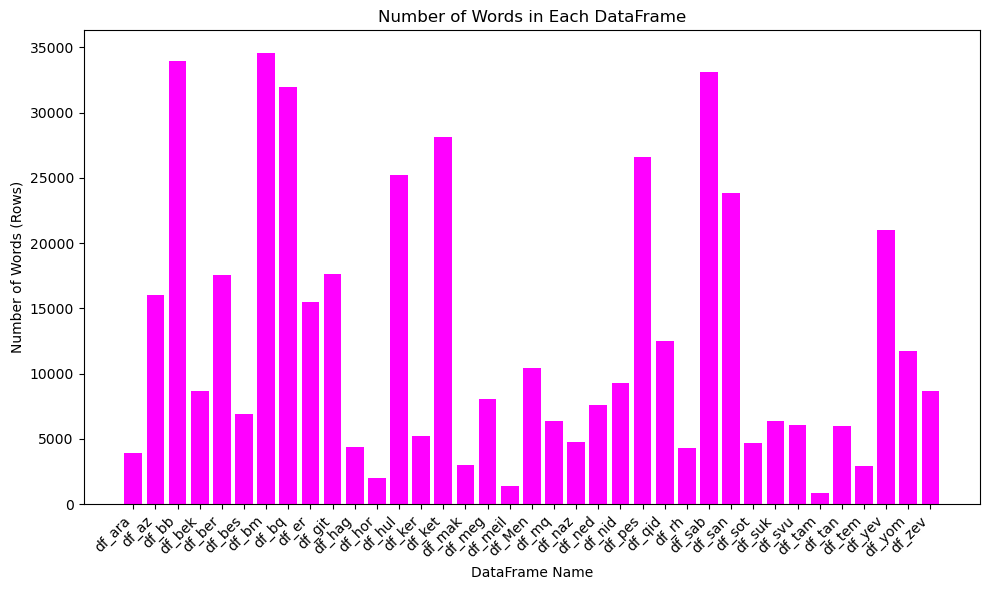

In [39]:
import matplotlib.pyplot as plt

# Dictionary to store DataFrame names and their row counts
df_row_counts = {df_name: globals()[df_name].shape[0] for df_name in arr_dfs}

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(df_row_counts.keys(), df_row_counts.values(), color='magenta')
plt.xlabel('DataFrame Name')
plt.ylabel('Number of Words')
plt.title('Number of Words in Each DataFrame')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


# Count of "verb" in merged_lexicon Column for Each Masekhet

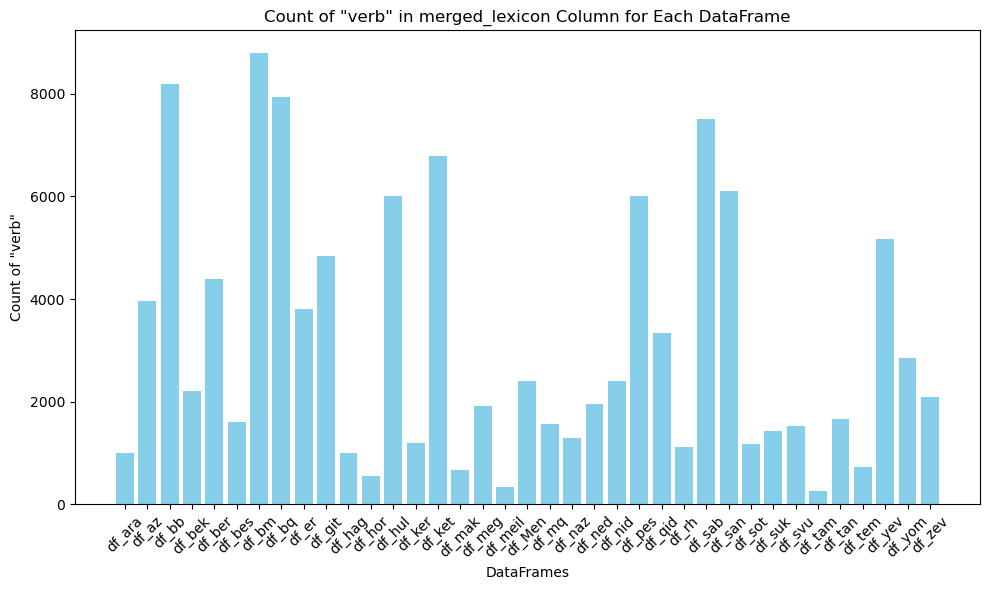

In [41]:
# Dictionary to store counts of 'verb' for each DataFrame
verb_counts = {}

# Count occurrences of 'verb' in the 'merged_lexicon' column for each DataFrame
for df_name in arr_dfs:
    df = globals().get(df_name)  # Retrieve the DataFrame by name
    if df is not None:
        count = df['merged_lexicon'].str.contains('verb', case=False, na=False).sum()
        verb_counts[df_name] = count

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(verb_counts.keys(), verb_counts.values(), color='skyblue')
plt.xlabel('DataFrames')
plt.ylabel('Count of "verb"')
plt.title('Count of "verb" in merged_lexicon Column for Each DataFrame')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
def print_unique_values_with_verb(df):
    lexicon_columns = [f'lexicon_{i}' for i in range(5)]  # Adjust if you have more/less columns
    
    for column in lexicon_columns:
        if column in df.columns:
            # Get unique values in the column
            unique_values = df[column].dropna().unique()
            # Filter values containing 'verb'
            verb_values = [value for value in unique_values if 'verb' in str(value).lower()]
            
            if verb_values:
                print(f"Unique values containing 'verb' in column '{column}':")
                for value in verb_values:
                    print(f"  {value}")
                print()  # Add a blank line for readability

# Iterate over DataFrame names and print unique values containing 'verb'
for df_name in arr_dfs:
    df = globals().get(df_name)  # Retrieve the DataFrame by name
    if df is not None:
        print(f"DataFrame: {df_name}")
        print_unique_values_with_verb(df)
    else:
        print(f"DataFrame {df_name} does not exist.")

DataFrame: df_ara
Unique values containing 'verb' in column 'lexicon_0':
  verb D
  verb G
  verb Dt
  verb C
  verb Gt
  verb quad
  verb quad T
  verb Ct

Unique values containing 'verb' in column 'lexicon_1':
  verb G
  verb C
  verb D
  verb Gt
  verb Dt
  verb quad

DataFrame: df_az
Unique values containing 'verb' in column 'lexicon_0':
  verb G
  verb Dt
  verb quad T
  verb C
  verb D
  verb Gt
  verb quad
  verb ethpolal, ethpay/w

Unique values containing 'verb' in column 'lexicon_1':
  verb G
  verb quad
  verb Dt
  verb C
  verb D
  verb Gt
  verb Ct

Unique values containing 'verb' in column 'lexicon_2':
  verb G
  verb D

Unique values containing 'verb' in column 'lexicon_3':
  verb G
  verb D

DataFrame: df_bb
Unique values containing 'verb' in column 'lexicon_0':
  verb G
  verb Gt
  verb C
  verb Dt
  verb D
  verb quad T
  verb palpel
  verb quad
  verb Ct

Unique values containing 'verb' in column 'lexicon_1':
  verb G
  verb C
  verb Dt
  verb D
  verb Gt
  verb quad

Unique values containing 'verb' in column 'lexicon_0':
  verb G
  verb C
  verb Gt
  verb D
  verb quad
  verb quad T
  verb Dt
  verb Ct

Unique values containing 'verb' in column 'lexicon_1':
  verb G
  verb D
  verb C
  verb Gt
  verb Dt
  verb Ct
  verb quad T

Unique values containing 'verb' in column 'lexicon_2':
  verb G
  verb D

DataFrame: df_tem
Unique values containing 'verb' in column 'lexicon_0':
  verb Gt
  verb G
  verb D
  verb C
  verb Dt
  verb Ct

Unique values containing 'verb' in column 'lexicon_1':
  verb Dt
  verb D
  verb G
  verb C
  verb Gt
  verb Ct

DataFrame: df_yev
Unique values containing 'verb' in column 'lexicon_0':
  verb G
  verb D
  verb C
  verb Gt
  verb Dt
  verb Ct
  verb quad
  verb palpel
  verb quad T

Unique values containing 'verb' in column 'lexicon_1':
  verb G
  verb Dt
  verb D
  verb C
  verb Gt
  verb quad
  verb Ct
  verb palpel

Unique values containing 'verb' in column 'lexicon_2':
  verb G
  verb C
  verb Dt

DataFrame: df_yom
Uniq